In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
from scipy import stats
import optuna

In [ ]:
import scipy.stats as stats


def box_muller(n_samples: int, seed: int = None):
    """Generate n_samples standard normal random variables using the Box-Muller transform."""
    if seed is not None:
        np.random.seed(seed)

    u1 = np.random.uniform(0, 1, n_samples // 2)
    u2 = np.random.uniform(0, 1, n_samples // 2)

    # Box-Muller transform
    r = np.sqrt(-2 * np.log(u1))
    theta = 2 * np.pi * u2
    z0 = r * np.cos(theta)
    z1 = r * np.sin(theta)

    return z0, z1

# Generate samples
z0, z1 = box_muller(10000, seed=42)

# 2D histogram (hexbin)
plt.figure(figsize=(6, 5))
plt.hexbin(z0, z1, gridsize=50, cmap='viridis', bins='log')
plt.colorbar(label='log10(N)')
plt.xlabel("z0")
plt.ylabel("z1")
plt.title("2D Histogram (Hexbin) of Box-Muller Samples")
plt.axis('equal')
plt.show()

# KS test for marginal distributions
ks_stat_z0, p_value_z0 = stats.kstest(z0, 'norm')
ks_stat_z1, p_value_z1 = stats.kstest(z1, 'norm')

print(f"KS Test for z0: stat = {ks_stat_z0:.4f}, p = {p_value_z0:.4f}")
print(f"KS Test for z1: stat = {ks_stat_z1:.4f}, p = {p_value_z1:.4f}")

if p_value_z0 > 0.05 and p_value_z1 > 0.05:
    print("Both z0 and z1 samples likely follow a standard normal distribution.")
else:
    print("One or both of z0 and z1 do not appear to follow a standard normal distribution.")

[I 2025-04-15 18:25:46,202] A new study created in memory with name: no-name-d6d72bc7-f3dc-49f7-a0b3-ce001a451852
/var/folders/50/yzx_7srn6kg7pvy80vjm6qww0000gn/T/ipykernel_5884/135234904.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
/Users/imangill/Desktop/DIS/HEP/igf23/.venv/lib/python3.9/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [128, 128] which is of type list.
  warnings.warn(message)
/Users/imangill/Desktop/DIS/HEP/igf23/.venv/lib/python3.9/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage 

Best trial:
  Value:  0.04704558476805687
  Params: 
    learning_rate: 0.0007494691458355726
    num_flows: 6
    hidden_units: [512, 512]
    batch_size: 512
    patience: 432
Final Model Step 0: loss = 2.178
Final Model Step 500: loss = 0.080
Final Model Step 1000: loss = 0.072
Final Model Step 1500: loss = 0.051
Final Model Step 2000: loss = 0.080
Final Model Step 2500: loss = 0.091
Final Model Step 3000: loss = 0.164
Final Model Step 3500: loss = 0.057
Final Model Step 4000: loss = 0.132
Final Model Step 4500: loss = 0.044


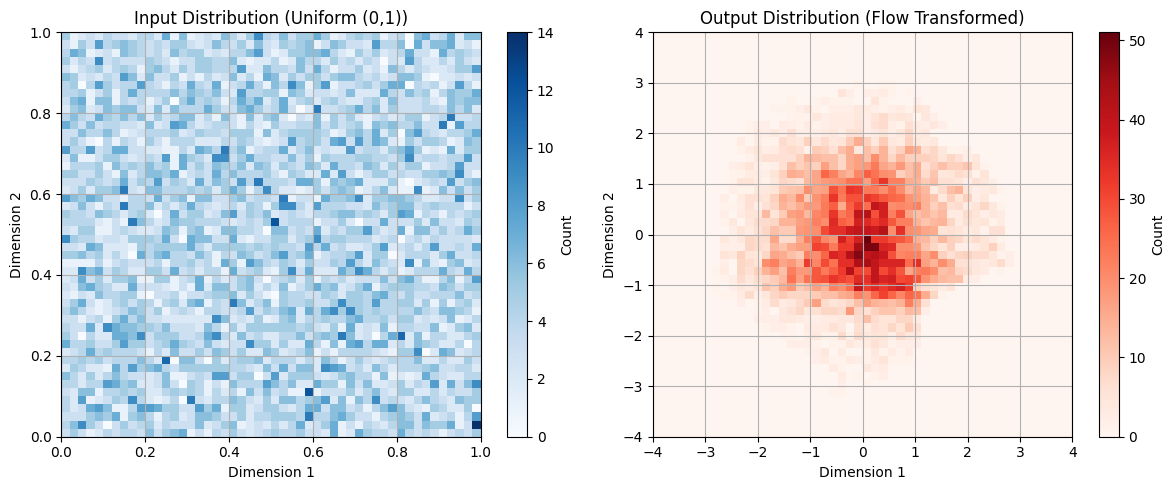

In [11]:
tfk = tf.keras
tfkl = tf.keras.layers
tfd = tfp.distributions
tfb = tfp.bijectors

# Helper to create a small Keras network for the shift and log-scale parameters.
def create_shift_and_log_scale_nn(hidden_layers, num_masked):
    return tf.keras.Sequential([
        tfkl.Dense(hidden_layers[0], activation='relu'),
        tfkl.Dense(hidden_layers[1], activation='relu'),
        tfkl.Dense(num_masked * 2, activation=None)
    ])

# Helper to create a RealNVP bijector with a custom Keras network.
def make_real_nvp_bijector(num_masked, hidden_layers):
    shift_log_scale_nn = create_shift_and_log_scale_nn(hidden_layers, num_masked)
    def shift_and_log_scale_fn(x, output_units, **kwargs):
        params = shift_log_scale_nn(x)
        shift, log_scale = tf.split(params, num_or_size_splits=2, axis=-1)
        return shift, log_scale
    bijector = tfb.RealNVP(
        num_masked=num_masked,
        shift_and_log_scale_fn=shift_and_log_scale_fn
    )
    # Attach the network so we can later register its variables
    bijector.shift_log_scale_nn = shift_log_scale_nn
    return bijector


class NormalizingFlowModel(tfk.Model):
    def __init__(self, flow_bijector, base_distribution, target_distribution):
        super(NormalizingFlowModel, self).__init__()
        self.flow_bijector = flow_bijector
        self.base_distribution = base_distribution
        self.target_distribution = target_distribution
        # Register each network as a sub-layer so that their variables are tracked.
        for i, bij in enumerate(self.flow_bijector.bijectors):
            if hasattr(bij, 'shift_log_scale_nn'):
                setattr(self, f"shift_log_scale_nn_{i}", bij.shift_log_scale_nn)
    
    def call(self, inputs):
        return self.flow_bijector.forward(inputs)
    
    def compute_loss(self, u):
        x = self.flow_bijector.forward(u)
        log_det = self.flow_bijector.forward_log_det_jacobian(u, event_ndims=1)
        log_prob_target = self.target_distribution.log_prob(x)
        loss = -tf.reduce_mean(log_prob_target + log_det)
        return loss

# Define the Optuna objective function.
def objective(trial):
    # Suggest hyperparameters.
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    num_flows = trial.suggest_int('num_flows', 2, 6)  # number of RealNVP blocks
    hidden_units = trial.suggest_categorical('hidden_units', [[128, 128], [256, 256], [512, 512]])
    batch_size = trial.suggest_categorical('batch_size', [128, 256, 512])
    patience = trial.suggest_int('patience', 100, 500)
    
    # Training parameters.
    num_steps = 5000  # maximum training steps
    eval_interval = 100  # how often to evaluate the loss for early stopping

    # Define the base and target distributions.
    base_distribution = tfd.Independent(
        tfd.Uniform(low=tf.zeros(2), high=tf.ones(2)),
        reinterpreted_batch_ndims=1
    )
    target_distribution = tfd.MultivariateNormalDiag(
        loc=tf.zeros(2), scale_diag=tf.ones(2)
    )
    
    # Create a chain of bijectors.
    bijectors = []
    for i in range(num_flows):
        bijectors.append(make_real_nvp_bijector(num_masked=1, hidden_layers=hidden_units))
        bijectors.append(tfb.Permute(permutation=[1, 0]))
    # When chaining bijectors the order is reversed.
    flow_bijector = tfb.Chain(list(reversed(bijectors)))
    
    # Build the normalizing flow model.
    nf_model = NormalizingFlowModel(flow_bijector, base_distribution, target_distribution)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    best_loss = float('inf')
    patience_counter = 0

    # Training loop.
    for step in range(num_steps):
        u_batch = base_distribution.sample(batch_size)
        with tf.GradientTape() as tape:
            loss = nf_model.compute_loss(u_batch)
        gradients = tape.gradient(loss, nf_model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, nf_model.trainable_variables))
        
        # Evaluate and report loss every eval_interval steps.
        if step % eval_interval == 0:
            u_val = base_distribution.sample(batch_size)
            val_loss = nf_model.compute_loss(u_val).numpy()
            trial.report(val_loss, step)
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()
            # Check for early stopping: reset counter on improvement.
            if val_loss < best_loss:
                best_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += eval_interval
            if patience_counter > patience:
                break

    return best_loss

# Run the study.
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

# Print best trial results.
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Extract best hyperparameters.
best_params = trial.params
final_learning_rate = best_params['learning_rate']
final_num_flows = best_params['num_flows']
final_hidden_units = best_params['hidden_units']
final_batch_size = best_params['batch_size']

# Define distributions.
base_distribution = tfd.Independent(
    tfd.Uniform(low=tf.zeros(2), high=tf.ones(2)),
    reinterpreted_batch_ndims=1
)
target_distribution = tfd.MultivariateNormalDiag(
    loc=tf.zeros(2), scale_diag=tf.ones(2)
)

# Create bijector chain using best hyperparameters.
bijectors = []
for i in range(final_num_flows):
    bijectors.append(make_real_nvp_bijector(num_masked=1, hidden_layers=final_hidden_units))
    bijectors.append(tfb.Permute(permutation=[1, 0]))
flow_bijector = tfb.Chain(list(reversed(bijectors)))

# Build final model.
final_model = NormalizingFlowModel(flow_bijector, base_distribution, target_distribution)
optimizer = tf.keras.optimizers.Adam(learning_rate=final_learning_rate)

# Retrain the final model.
num_steps_final = 5000
for step in range(num_steps_final):
    u_batch = base_distribution.sample(final_batch_size)
    with tf.GradientTape() as tape:
        loss = final_model.compute_loss(u_batch)
    gradients = tape.gradient(loss, final_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, final_model.trainable_variables))
    if step % 500 == 0:
        print(f"Final Model Step {step}: loss = {loss.numpy():.3f}")

# Plot binned histogram of the input (base) and output (transformed) distributions.
n_samples = 10000
u_samples = base_distribution.sample(n_samples)
u_samples_np = u_samples.numpy()
x_samples = final_model.flow_bijector.forward(u_samples)
x_samples_np = x_samples.numpy()

plt.figure(figsize=(12, 5))

# Input distribution histogram.
plt.subplot(1, 2, 1)
hist_input = plt.hist2d(u_samples_np[:, 0], u_samples_np[:, 1],
                         bins=50, range=[[0, 1], [0, 1]], cmap='Blues')
plt.title("Input Distribution (Uniform (0,1))")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.colorbar(hist_input[-1], label='Count')
plt.grid(True)

# Output distribution histogram.
plt.subplot(1, 2, 2)
hist_output = plt.hist2d(x_samples_np[:, 0], x_samples_np[:, 1],
                          bins=50, range=[[-4, 4], [-4, 4]], cmap='Reds')
plt.title("Output Distribution (Flow Transformed)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.colorbar(hist_output[-1], label='Count')
plt.grid(True)

plt.tight_layout()
plt.show()


In [44]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions

tf.random.set_seed(290301)

# Define base and target distributions
base_dist = tfd.Independent(
    tfd.Uniform(low=[0., 0.], high=[1., 1.]),
    reinterpreted_batch_ndims=1
)
target_dist = tfd.MultivariateNormalDiag(loc=[0., 0.], scale_diag=[1., 1.])

#  safe logit bijector with better numerical stability
class SafeLogit(tfp.bijectors.Bijector):
    def __init__(self, eps=1e-5, validate_args=False, name="safe_logit"):
        super(SafeLogit, self).__init__(
            forward_min_event_ndims=0, validate_args=validate_args, name=name)
        self.eps = eps

    def _forward(self, x):
        # Clip x to avoid exactly 0 or 1.
        x = tf.clip_by_value(x, self.eps, 1 - self.eps)
        return tf.math.log(x / (1 - x))

    def _inverse(self, y):
        # Use stable sigmoid implementation
        # When y is large, exp(-y) is small and sigmoid(y) ≈ 1 - exp(-y)
        # When y is small, sigmoid(y) ≈ exp(y) / (1 + exp(y)) is accurate
        return tf.where(y > 0, 
                        1. / (1. + tf.exp(-y)), 
                        tf.exp(y) / (1. + tf.exp(y)))

    def _forward_log_det_jacobian(self, x):
        x = tf.clip_by_value(x, self.eps, 1 - self.eps)
        # Numerically stable implementation
        return -tf.math.log(x) - tf.math.log(1 - x)

    def _inverse_log_det_jacobian(self, y):

        log_sigmoid = -tf.math.softplus(-y)
        log_one_minus_sigmoid = -tf.math.softplus(y)
        return log_sigmoid + log_one_minus_sigmoid

# Neural network for shift and log scale functions with gradient stabilization
def shift_and_log_scale_nn(hidden_units, num_masked):
    model = keras.Sequential()
    for units in hidden_units:
        model.add(layers.Dense(units, activation="relu"))
        # Add batch normalization for more stable gradients
        # model.add(layers.BatchNormalization())
    model.add(layers.Dense(num_masked * 2, activation=None))
    return model

# Build a RealNVP bijector with clamping for stability
def make_rnvp_bijector(num_masked, hidden_units):
    nn_model = shift_and_log_scale_nn(hidden_units, num_masked)
    # Force building the network
    dummy_input = tf.zeros((1, 1))
    nn_model(dummy_input)

    def shift_and_log_scale_fn(x, output_units, **kwargs):
        params = nn_model(x)
        shift, log_scale_raw = tf.split(params, num_or_size_splits=2, axis=-1)
        log_scale = tf.clip_by_value(log_scale_raw, -5.0, 5.0)
        return shift, log_scale_raw

    bijector = tfb.RealNVP(
        num_masked=num_masked,
        shift_and_log_scale_fn=shift_and_log_scale_fn
    )
    bijector.nn_model = nn_model
    return bijector

# Build the chain of bijectors - keep the original number of flows
num_flows = 6
bijectors = []
networks = []
for i in range(num_flows):
    rnvp = make_rnvp_bijector(num_masked=1, hidden_units=[512, 512])
    networks.append(rnvp.nn_model)
    bijectors.append(rnvp)
    bijectors.append(tfb.Permute(permutation=[1, 0]))

# Create the RealNVP chain with improved logit
g = tfb.Chain(list(reversed(bijectors)))
flow_bijector = tfb.Chain([
    g,
    SafeLogit(eps=1e-5)
])


class NormalizingFlow(keras.Model):
    def __init__(self, flow_bijector, base_dist, target_dist, networks):
        super(NormalizingFlow, self).__init__()
        self.flow_bijector = flow_bijector
        self.base_dist = base_dist
        self.target_dist = target_dist
        # Register each neural network
        for i, net in enumerate(networks):
            self.__setattr__(f"nn_{i}", net)
    
    def call(self, inputs, training=None, reverse=False):
        if not reverse:
            return self.flow_bijector.forward(inputs)
        else:
            return self.flow_bijector.inverse(inputs)
    
    def compute_loss(self, x, reverse=False):
        if not reverse:
            # Forward direction: base → target
            z = self.flow_bijector.forward(x)
            log_det = self.flow_bijector.forward_log_det_jacobian(x, event_ndims=1)
            log_prob_target = self.target_dist.log_prob(z)
            # Apply gradient clipping via tf.clip_by_value
            log_det = tf.clip_by_value(log_det, -100, 100)
            log_prob_target = tf.clip_by_value(log_prob_target, -100, 100)
            loss = -tf.reduce_mean(log_prob_target + log_det)
            # Add a small L2 regularization for stability
            l2_reg = 1e-5 * tf.reduce_sum([tf.nn.l2_loss(v) for v in self.trainable_variables])
            return loss + l2_reg
        else:
            # Reverse direction: target → base
            z = self.flow_bijector.inverse(x)
            log_det = self.flow_bijector.inverse_log_det_jacobian(x, event_ndims=1)
            log_prob_base = self.base_dist.log_prob(z)
            # Apply gradient clipping
            log_det = tf.clip_by_value(log_det, -100, 100)
            log_prob_base = tf.clip_by_value(log_prob_base, -100, 100)
            loss = -tf.reduce_mean(log_prob_base + log_det)
            # Add a small L2 regularization for stability
            l2_reg = 1e-5 * tf.reduce_sum([tf.nn.l2_loss(v) for v in self.trainable_variables])
            return loss + l2_reg
    
    # Debug method to identify NaN values
    def debug_nan(self, x, reverse=False):
        if not reverse:
            # Forward direction
            z = self.flow_bijector.forward(x)
            log_det = self.flow_bijector.forward_log_det_jacobian(x, event_ndims=1)
            log_prob = self.target_dist.log_prob(z)
            return {
                'z_nan': tf.reduce_any(tf.math.is_nan(z)),
                'log_det_nan': tf.reduce_any(tf.math.is_nan(log_det)),
                'log_prob_nan': tf.reduce_any(tf.math.is_nan(log_prob))
            }
        else:
            # Reverse direction
            z = self.flow_bijector.inverse(x)
            log_det = self.flow_bijector.inverse_log_det_jacobian(x, event_ndims=1)
            log_prob = self.base_dist.log_prob(z)
            return {
                'z_nan': tf.reduce_any(tf.math.is_nan(z)),
                'log_det_nan': tf.reduce_any(tf.math.is_nan(log_det)),
                'log_prob_nan': tf.reduce_any(tf.math.is_nan(log_prob))
            }

# Create the model
nf_model = NormalizingFlow(flow_bijector, base_dist, target_dist, networks)


# Set up the optimizer with gradient clipping for stability
optimizer = keras.optimizers.Adam(learning_rate=0.0007494691458355726)
batch_size = 128
epochs = 1000
max_grad_norm = 1.0  # For gradient clipping

# Gradient clipping callback for training
def apply_gradients_with_clipping(optimizer, gradients, variables, max_norm):
    # Clip the gradients
    clipped_gradients, _ = tf.clip_by_global_norm(gradients, max_norm)
    # Apply the clipped gradients
    optimizer.apply_gradients(zip(clipped_gradients, variables))


print("Starting forward training")
for i in range(epochs):
    base_batch = base_dist.sample(batch_size)
    with tf.GradientTape() as tape:
        loss = nf_model.compute_loss(base_batch)
    
    # Check for NaN
    if tf.math.is_nan(loss):
        debug_info = nf_model.debug_nan(base_batch)
        print(f"NaN detected at step {i}. Debug info:", debug_info)
        # Try reducing batch size and learning rate to recover
        optimizer.learning_rate = optimizer.learning_rate * 0.5
        batch_size = max(32, batch_size // 2)
        print(f"Reducing learning rate to {optimizer.learning_rate.numpy()} and batch size to {batch_size}")
        continue
    
    gradients = tape.gradient(loss, nf_model.trainable_variables)
    # Apply gradients with clipping
    apply_gradients_with_clipping(optimizer, gradients, nf_model.trainable_variables, max_grad_norm)
    
    if loss.numpy() < 0.01:
        print(f"Forward training converged at step {i} with loss {loss.numpy()}")
        break
        
    if i % 100 == 0:
        print(f"Forward training - Step: {i}, Loss: {loss.numpy()}")

# Reset optimizer for reverse training with slower learning rate
optimizer = keras.optimizers.Adam(learning_rate=5e-6)  # Lower learning rate for reverse direction

# Reverse training: mapping from target (ℝ²) to base ([0,1]^2)
print("Starting reverse training")
for i in range(epochs):
    target_batch = target_dist.sample(batch_size)
    with tf.GradientTape() as tape:
        loss = nf_model.compute_loss(target_batch, reverse=True)
    
    # Check for NaN
    if tf.math.is_nan(loss):
        debug_info = nf_model.debug_nan(target_batch, reverse=True)
        print(f"NaN detected at step {i}. Debug info:", debug_info)
        # Try reducing batch size and learning rate to recover
        optimizer.learning_rate = optimizer.learning_rate * 0.5
        batch_size = max(32, batch_size // 2)
        print(f"Reducing learning rate to {optimizer.learning_rate.numpy()} and batch size to {batch_size}")
        continue
    
    gradients = tape.gradient(loss, nf_model.trainable_variables)
    # Apply gradients with clipping
    apply_gradients_with_clipping(optimizer, gradients, nf_model.trainable_variables, max_grad_norm)
    
    if loss.numpy() < 1.0:  # Looser criterion for reverse
        print(f"Reverse training reached target at step {i} with loss {loss.numpy()}")
        break
        
    if i % 100 == 0:
        print(f"Reverse training - Step: {i}, Loss: {loss.numpy()}")

Starting forward training
Forward training - Step: 0, Loss: 2.0634446144104004
Forward training - Step: 100, Loss: 0.026071863248944283
Forward training converged at step 110 with loss 0.008603759109973907
Starting reverse training
Reverse training - Step: 0, Loss: 2.865309476852417
Reverse training - Step: 100, Loss: 2.9704275131225586
Reverse training - Step: 200, Loss: 2.914839506149292
Reverse training - Step: 300, Loss: 2.759779453277588
Reverse training - Step: 400, Loss: 2.758870840072632
Reverse training - Step: 500, Loss: 2.87908935546875
Reverse training - Step: 600, Loss: 2.7821097373962402
Reverse training - Step: 700, Loss: 2.8664252758026123
Reverse training - Step: 800, Loss: 3.028823137283325
Reverse training - Step: 900, Loss: 2.7562906742095947


In [46]:

from tqdm import tqdm
import os

def rejection_sample_forward(model, n_samples, M):
    # Standard normal PDF calculation
    def gaussian_pdf(x):
        norm_const = 1.0 / (2 * np.pi)
        return norm_const * tf.exp(-0.5 * tf.reduce_sum(x**2, axis=-1))
    
    accepted_samples = []
    count = 0
    
    try:
        from tqdm import tqdm
        progress_bar = tqdm(total=n_samples, desc="Forward Rejection Sampling")
    except ImportError:
        progress_bar = None
    
    while len(accepted_samples) < n_samples:
        # Sample from the base distribution
        u = model.base_dist.sample(1)
        
        # Apply forward transformation (base → target)
        x = model.call(u)
        
        # Get the log determinant of Jacobian
        log_det = model.flow_bijector.forward_log_det_jacobian(u, event_ndims=1)
        
        # Compute proposal density
        q_val = tf.exp(-log_det[0])
        
        # Compute target density for the transformed point
        p_val = gaussian_pdf(x)[0]
        
        # Compute acceptance probability
        accept_prob = p_val / (M * q_val)
        random_u = tf.random.uniform(shape=[])
        
        if random_u < accept_prob:
            accepted_samples.append(x[0])
            if progress_bar:
                progress_bar.update(1)
        
        count += 1
        if count > 100000:  # Safety break
            break
    
    if progress_bar:
        progress_bar.close()
    
    if accepted_samples:
        accepted_samples = tf.stack(accepted_samples, axis=0)
        acceptance_rate = len(accepted_samples) / count
        return accepted_samples, acceptance_rate
    else:
        return tf.zeros((0, 2)), 0.0


def rejection_sample_backward(model, n_samples, M):
    # Uniform PDF on [0,1]²
    def uniform_pdf(x):
        cond = tf.reduce_all(tf.logical_and(x >= 0.0, x <= 1.0), axis=-1)
        return tf.where(cond, tf.ones_like(tf.reduce_sum(x, axis=-1)), tf.zeros_like(tf.reduce_sum(x, axis=-1)))
    
    accepted_samples = []
    count = 0
    
    try:
        from tqdm import tqdm
        progress_bar = tqdm(total=n_samples, desc="Backward Rejection Sampling")
    except ImportError:
        progress_bar = None
    
    while len(accepted_samples) < n_samples:
        # Sample from the target distribution
        z = model.target_dist.sample(1)
        
        # Apply inverse transformation (target → base)
        u = model.call(z, reverse=True)
        
        # Get the log determinant of inverse Jacobian
        log_det_inv = model.flow_bijector.inverse_log_det_jacobian(z, event_ndims=1)
        
        # Compute proposal density for inverse transformation
        q_val = tf.exp(log_det_inv[0])
        
        # Compute target density (uniform) for the transformed point
        p_val = uniform_pdf(u)[0]
        
        # Compute acceptance probability
        accept_prob = p_val / (M * q_val)
        random_u = tf.random.uniform(shape=[])
        
        if random_u < accept_prob:
            accepted_samples.append(u[0])
            if progress_bar:
                progress_bar.update(1)
        
        count += 1
        if count > 100000:  # Safety break
            break
    
    if progress_bar:
        progress_bar.close()
    
    if accepted_samples:
        accepted_samples = tf.stack(accepted_samples, axis=0)
        acceptance_rate = len(accepted_samples) / count
        return accepted_samples, acceptance_rate
    else:
        return tf.zeros((0, 2)), 0.0


def plot_rejection_samples(forward_samples, backward_samples, forward_rate, backward_rate, suffix=""):

    plt.figure(figsize=(12, 6))
    
    # Forward rejection samples (should look like a Gaussian)
    plt.subplot(1, 2, 1)
    if len(forward_samples) > 0:
        plt.hist2d(forward_samples[:, 0], forward_samples[:, 1], bins=40, cmap='viridis', 
                  range=[[-4, 4], [-4, 4]], density=True)
    plt.title(f"Forward Rejection Samples\nAcceptance Rate: {forward_rate:.4f}", fontsize=12)
    plt.xlabel("x₁", fontsize=11)
    plt.ylabel("x₂", fontsize=11)
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)
    
    # Backward rejection samples (should look like a uniform distribution)
    plt.subplot(1, 2, 2)
    if len(backward_samples) > 0:
        plt.hist2d(backward_samples[:, 0], backward_samples[:, 1], bins=40, cmap='plasma', 
                  range=[[-0.1, 1.1], [-0.1, 1.1]], density=True)
    plt.title(f"Backward Rejection Samples\nAcceptance Rate: {backward_rate:.4f}", fontsize=12)
    plt.xlabel("u1", fontsize=11)
    plt.ylabel("u2", fontsize=11)
    plt.xlim(-0.1, 1.1)
    plt.ylim(-0.1, 1.1)
    
    plt.tight_layout()
    
    # Create plots directory if it doesn't exist
    if not os.path.exists("plots"):
        os.makedirs("plots")
        
    plt.savefig(os.path.join("plots", f"rejection_samples_{suffix}.png"), dpi=300)
    plt.close()


def run_rejection_sampling(model, suffix):
    print(f"Performing rejection sampling ({suffix})...")
    
    # Forward rejection sampling
    M_forward = 1.5
    forward_samples, forward_rate = rejection_sample_forward(
        model, 
        n_samples=1000, 
        M=M_forward
    )
    print(f"Forward rejection sampling acceptance rate ({suffix}): {forward_rate:.4f}")
    
    # Backward rejection sampling
    M_backward = 1.5
    backward_samples, backward_rate = rejection_sample_backward(
        model, 
        n_samples=1000, 
        M=M_backward
    )
    print(f"Backward rejection sampling acceptance rate ({suffix}): {backward_rate:.4f}")
    
    # Plot rejection samples
    plot_rejection_samples(
        forward_samples.numpy(), 
        backward_samples.numpy(), 
        forward_rate, 
        backward_rate,
        suffix=suffix
    )
    
    return forward_rate, backward_rate


def create_phi4_potential(x, y, m2=-1.0, lam=1.0):

    phi = np.stack((x, y), axis=-1)
    # Compute discrete gradient squared terms (kinetic energy)
    phi_x_diff = np.diff(phi, axis=0)
    phi_y_diff = np.diff(phi, axis=1)
    # Pad to original shape
    phi_x_diff = np.pad(phi_x_diff, ((0, 1), (0, 0), (0, 0)), mode='edge')
    phi_y_diff = np.pad(phi_y_diff, ((0, 0), (0, 1), (0, 0)), mode='edge')
    # Compute kinetic term
    kinetic = 0.5 * (phi_x_diff**2 + phi_y_diff**2)
    # Compute potential term
    potential = 0.5 * m2 * phi**2 + (lam/24.0) * phi**4
    
    # Total action density
    action_density = kinetic.sum(axis=-1) + potential.sum(axis=-1)
    
    return action_density


def plot_phi4_action():
    """Generate random field configurations and evaluate the phi^4 action."""
    # Create a 10x10 lattice
    L = 10
    
    # Generate 4 random field configurations
    np.random.seed(1511)
    configs = []
    action_values = []
    
    for i in range(4):
        # Random field with different scales to show action differences
        phi = np.random.normal(0, 0.5 * (i + 1), size=(L, L, 2))
        configs.append(phi)
        
        # Compute action
        action = create_phi4_potential(phi[:,:,0], phi[:,:,1])
        action_values.append(np.sum(action))
    
    # Plot configurations and their actions
    plt.figure(figsize=(16, 4))
    
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.imshow(configs[i][:,:,0], cmap='viridis', vmin=-2, vmax=2)
        plt.colorbar(label=r'$\phi_1$')
        plt.title(f"Config {i+1}\nAction = {action_values[i]:.2f}")
        plt.tight_layout()
    
    # Create plots directory if it doesn't exist
    if not os.path.exists("plots"):
        os.makedirs("plots")
        
    plt.savefig(os.path.join("plots", "phi4_action.png"), dpi=300)
    plt.close()
    
    # Display how the action value grows with field magnitude
    mags = [0.5, 1.0, 1.5, 2.0]
    actions = []
    
    for mag in mags:
        phi = np.random.normal(0, mag, size=(L, L, 2))
        action = create_phi4_potential(phi[:,:,0], phi[:,:,1])
        actions.append(np.sum(action))
    
    plt.figure(figsize=(8, 6))
    plt.plot(mags, actions, 'o-', linewidth=2)
    plt.xlabel("Field Magnitude Scale", fontsize=12)
    plt.ylabel(r"Action $S[\phi]$", fontsize=12)
    plt.title(r"Scaling of $\phi^4$ Action with Field Magnitude", fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join("plots", "phi4_action_scaling.png"), dpi=300)
    plt.close()

In [43]:
nf_model_untrained = NormalizingFlow(flow_bijector, base_dist, target_dist, networks)
sample_input = base_dist.sample(1)
_ = nf_model_untrained(sample_input)  # Forward pass to build
run_rejection_sampling(nf_model_untrained, "untrained")

Performing rejection sampling (untrained)...


Forward Rejection Sampling: 100%|██████████| 1000/1000 [02:30<00:00,  6.63it/s]


Forward rejection sampling acceptance rate (untrained): 0.5476


Backward Rejection Sampling: 100%|██████████| 1000/1000 [01:29<00:00, 11.13it/s]


Backward rejection sampling acceptance rate (untrained): 1.0000


(0.547645125958379, 1.0)

In [37]:
run_rejection_sampling(nf_model, "final")

Performing rejection sampling (final)...


Forward Rejection Sampling: 100%|██████████| 1000/1000 [02:03<00:00,  8.08it/s]


Forward rejection sampling acceptance rate (final): 0.6515


Backward Rejection Sampling: 100%|██████████| 1000/1000 [01:26<00:00, 11.51it/s]


Backward rejection sampling acceptance rate (final): 1.0000


(0.6514657980456026, 1.0)

In [47]:
plot_phi4_action()